# Using a neural network to fit the data

![Figure_6.1.png](Images_ch6/Figure_6.1.png)

## 6.1 Artificial neurons

At the core of deep learning are neural networks: mathematical entities capable of
representing complicated functions through a composition of simpler functions. The
term neural network is obviously suggestive of a link to the way our brain works.

At its core, it is nothing but a linear transformation of the input (for exam-
ple, multiplying the input by a number [the weight] and adding a constant [the bias])
followed by the application of a fixed nonlinear function (referred to as the activation
function).
Mathematically, we can write this out as o = f(w * x + b), with x as our input, w our
weight or scaling factor, and b as our bias or offset. f is our activation function, set to
the hyperbolic tangent, or tanh function here. In general, x and, hence, o can be sim-
ple scalars, or vector-valued (meaning holding many scalar values); and similarly, w can be a single scalar or matrix, while b is a scalar or vector (the dimensionality of the
inputs and weights must match, however). In the latter case, the previous expression is
referred to as a layer of neurons, since it represents many neurons via the multidimen-
sional weights and biases.

![Figure_6.2.png](Images_ch6/Figure_6.2.png)

Remember that w_0 here is a matrix, and x is a vector! Using a vector allows w_0 to
hold an entire layer of neurons, not just a single weight.

![Figure_6.3.png](Images_ch6/Figure_6.3.png)

An important difference between our earlier linear model and what we’ll actually be
using for deep learning is the shape of the error function. Our linear model and
error-squared loss function had a convex error curve with a singular, clearly defined
minimum. If we were to use other methods, we could solve for the parameters mini-
mizing the error function automatically and definitively. That means that our parame-
ter updates were attempting to estimate that singular correct answer as best they could.

Neural networks do not have that same property of a convex error surface, even
when using the same error-squared loss function! There’s no single right answer for
each parameter we’re attempting to approximate. Instead, we are trying to get all of
the parameters, when acting in concert, to produce a useful output. Since that useful
output is only going to approximate the truth, there will be some level of imperfection.
Where and how imperfections manifest is somewhat arbitrary, and by implication the
parameters that control the output (and, hence, the imperfections) are somewhat
arbitrary as well. This results in neural network training looking very much like
parameter estimation from a mechanical perspective, but we must remember that the
theoretical underpinnings are quite different.
A big part of the reason neural networks have non-convex error surfaces is due to
the activation function. The ability of an ensemble of neurons to approximate a very
wide range of useful functions depends on the combination of the linear and nonlin-
ear behavior inherent to each neuron.

As we have seen, the simplest unit in (deep) neural networks is a linear operation
(scaling + offset) followed by an activation function. We already had our linear opera-
tion in our latest model—the linear operation was the entire model. The activation
function plays two important roles:
* In the inner parts of the model, it allows the output function to have different
slopes at different values—something a linear function by definition cannot do.
By trickily composing these differently sloped parts for many outputs, neural
networks can approximate arbitrary functions, as we will see in section 6.1.6.2
* At the last layer of the network, it has the role of concentrating the outputs of
the preceding linear operation into a given range.

Let’s talk about what the second point means. Pretend that we’re assigning a “good
doggo” score to images. Pictures of retrievers and spaniels should have a high score,
while images of airplanes and garbage trucks should have a low score. Bear pictures
should have a lowish score, too, although higher than garbage trucks.
The problem is, we have to define a “high score”: we’ve got the entire range of
float32 to work with, and that means we can go pretty high. Even if we say “it’s a 10-point
scale,” there’s still the issue that sometimes our model is going to produce a score of 11
out of 10. Remember that under the hood, it’s all sums of (w*x+b) matrix multiplica-
tions, and those won’t naturally limit themselves to a specific range of outputs.

We want to firmly constrain the output of our linear operation to a specific range so
that the consumer of this output doesn’t have to handle numerical inputs of puppies
at 12/10, bears at –10, and garbage trucks at –1,000.
One possibility is to just cap the output values: anything below 0 is set to 0, and any-
thing above 10 is set to 10. That’s a simple activation function called torch.nn.Hardtanh
(https://pytorch.org/docs/stable/nn.html#hardtanh, but note that the default range
is –1 to +1).

In [1]:
import torch

In [2]:
from torch.nn import Hardtanh
m = Hardtanh(-2, 2)
input = torch.randn(2)
output = m(input)
print(output)
## Example taken from the mentioned above documentation  

tensor([-0.2912, -1.4793])


Another popular activation function is sigmoid

In [3]:
from torch.nn import Sigmoid
m = Sigmoid()
input = torch.randn(2)
output = m(input)
print(output)

tensor([0.6184, 0.7813])


![Figure_6.4.png](Images_ch6/Figure_6.4.png)

There are quite a few activation functions, some of which are shown in figure 6.5. In
the first column, we see the smooth functions Tanh and Softplus, while the second
column has “hard” versions of the activation functions to their left: Hardtanh and
ReLU. ReLU (for rectified linear unit) deserves special note, as it is currently considered one of the best-performing general activation functions; many state-of-the-art results
have used it.

![Figure_6.5.png](Images_ch6/Figure_6.5.png)

That said, by definition,
activation functions
* Are nonlinear. Repeated applications of (w*x+b) without an activation function
results in a function of the same (affine linear) form. The nonlinearity allows
the overall network to approximate more complex functions.
* Are differentiable, so that gradients can be computed through them. Point dis-
continuities, as we can see in Hardtanh or ReLU, are fine.

Without these characteristics, the network either falls back to being a linear model or
becomes difficult to train.
The following are true for the functions:
* They have at least one sensitive range, where nontrivial changes to the input
result in a corresponding nontrivial change to the output. This is needed for
training.
* Many of them have an insensitive (or saturated) range, where changes to the
input result in little or no change to the output.

Often (but far from universally so), the activation function will have at least one of
these:
* A lower bound that is approached (or met) as the input goes to negative infinity
* A similar-but-inverse upper bound for positive infinity

The four upper-left graphs show four neurons—A, B, C, and D—each with its own
(arbitrarily chosen) weight and bias. Each neuron uses the Tanh activation function
with a min of –1 and a max of 1. The varied weights and biases move the center point
and change how drastically the transition from min to max happens, but they clearly
all have the same general shape. The columns to the right of those show both pairs of
neurons added together (A + B and then C + D). Here, we start to see some interest-
ing properties that mimic a single layer of neurons. A + B shows a slight S curve, with
the extremes approaching 0, but both a positive bump and a negative bump in the
middle. Conversely, C + D has only a large positive bump, which peaks at a higher
value than our single-neuron max of 1.
In the third row, we begin to compose our neurons as they would be in a two-layer net-
work. Both C(A + B) and D(A + B) have the same positive and negative bumps that A + B
shows, but the positive peak is more subtle. The composition of C(A + B) + D(A + B) shows a new property: two clearly negative bumps, and possibly a very subtle second pos-
itive peak as well, to the left of the main area of interest. All this with only four neurons
in two layers!

![Figure_6.6.png](Images_ch6/Figure_6.6.png)

Deep neural networks, on the other hand, are families of functions that have
the ability to approximate a wide range of input/output relationships without neces-
sarily requiring us to come up with an explanatory model of a phenomenon. In a way,
we’re renouncing an explanation in exchange for the possibility of tackling increas-
ingly complicated problems. In another way, we sometimes lack the ability, informa-
tion, or computational resources to build an explicit model of what we’re presented
with, so data-driven methods are our only way forward.

# 6.2 The PyTorch nn module

Our first step will be to replace our linear
model with a neural network unit. This will be a somewhat useless step backward from
a correctness perspective, since we’ve already verified that our calibration only
required a linear function, but it will still be instrumental for starting on a sufficiently
simple problem and scaling up later.

PyTorch has a whole submodule dedicated to neural networks, called torch.nn. It
contains the building blocks needed to create all sorts of neural network architec-
tures.

Calling an instance of nn.Module with a set of arguments ends up calling a method
named forward with the same arguments. The forward method is what executes the
forward computation, while __call__ does other rather important chores before and
after calling forward. So, it is technically possible to call forward directly, and it will
produce the same output as __call__, but this should not be done from user code:

In [4]:
#y = model(x) Correct
#y = model.forward(x) Silent error. Don’t do it!

Back to our linear model. The constructor to nn.Linear accepts three arguments: the
number of input features, the number of output features, and whether the linear
model includes a bias or not

In [5]:
import torch
import torch.nn as nn
values = torch.tensor([0.6,0.2,0.11,0.123],dtype=torch.float32) # Numbers made thanks to me smashing my head on a keyboard

linear_model = nn.Linear(4, 1)
linear_model(values)

tensor([0.2735], grad_fn=<ViewBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[ 0.0510,  0.2596,  0.3413, -0.0791]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.1632], requires_grad=True)

In [8]:
linear_model = nn.Linear(1,1)
x = torch.ones(1)
linear_model(x)

tensor([0.8521], grad_fn=<ViewBackward0>)

Although PyTorch lets us get away with it, we don’t actually provide an input with the
right dimensionality. We have a model that takes one input and produces one output,
but PyTorch nn.Module and its subclasses are designed to do so on multiple samples at
the same time. To accommodate multiple samples, modules expect the zeroth dimen-
sion of the input to be the number of samples in the batch.

Any module in nn is written to produce outputs for a batch of multiple inputs at the
same time. Thus, assuming we need to run nn.Linear on 10 samples, we can create an
input tensor of size B × Nin, where B is the size of the batch and Nin is the number of
input features, and run it once through the model. For example:

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.8521],
        [0.8521],
        [0.8521],
        [0.8521],
        [0.8521],
        [0.8521],
        [0.8521],
        [0.8521],
        [0.8521],
        [0.8521]], grad_fn=<AddmmBackward0>)

![Figure_6.7.png](Images_ch6/Figure_6.7.png)

Back to our thermometer data, t_u and t_c were two 1D tensors of size B. Thanks
to broadcasting, we could write our linear model as w * x + b, where w and b were
two scalar parameters. This worked because we had a single input feature: if we had
two, we would need to add an extra dimension to turn that 1D tensor into a matrix
with samples in the rows and features in the columns.
That’s exactly what we need to do to switch to using nn.Linear. We reshape our B
inputs to B × Nin, where Nin is 1. That is easily done with unsqueeze:

In [10]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

In [11]:
import torch.optim as optim
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
linear_model.parameters(), # This method call replaces [params].
lr=1e-2)

Earlier, it was our responsibility to create parameters and pass them as the first argu-
ment to optim.SGD. Now we can use the parameters method to ask any nn.Module for
a list of parameters owned by it or any of its submodules:

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.4867]], requires_grad=True),
 Parameter containing:
 tensor([-0.9084], requires_grad=True)]

This call recurses into submodules defined in the module’s init constructor and
returns a flat list of all parameters encountered, so that we can conveniently pass it to
the optimizer constructor as we did previously.

In [13]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # The model is now passed in, instead of the individual params. 
        loss_train = loss_fn(t_p_train, t_c_train)
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        optimizer.zero_grad()
        loss_train.backward() # The loss function is also passed in. We’ll use it in a moment.
        optimizer.step()
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
            f" Validation loss {loss_val.item():.4f}")

In [14]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([3, 9, 6, 2, 1, 5, 4, 0, 7]), tensor([ 8, 10]))

In [15]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [16]:
training_loop(
n_epochs = 3000,
optimizer = optimizer,
model = linear_model,
loss_fn = nn.MSELoss(),# We are no longer using our hand-written loss function from earlier.
t_u_train = train_t_un,
t_u_val = val_t_un,
t_c_train = train_t_c,
t_c_val = val_t_c)

Epoch 1, Training loss 75.7578, Validation loss 99.1333
Epoch 1000, Training loss 3.0899, Validation loss 7.6144
Epoch 2000, Training loss 2.4510, Validation loss 5.7302
Epoch 3000, Training loss 2.4377, Validation loss 5.4854


Everything else input into our training loop stays the same. Even our results remain
the same as before. Of course, getting the same results is expected, as a difference
would imply a bug in one of the two implementations.

# 6.3 Finally a neural network

Let’s build the simplest possible neural network: a linear module, followed
by an activation function, feeding into another linear module

There is no standard way to depict neural networks. Figure 6.8 shows two ways that
seem to be somewhat prototypical: the left side shows how our network might be
depicted in basic introductions, whereas a style similar to that on the right is often
used in the more advanced literature and research papers. It is common to make dia-
gram blocks that roughly correspond to the neural network modules PyTorch offers
(though sometimes things like the Tanh activation layer are not explicitly shown).
Note that one somewhat subtle difference between the two is that the graph on the
left has the inputs and (intermediate) results in the circles as the main elements. On
the right, the computational steps are more prominent.

![Figure_6.8.png](Images_ch6/Figure_6.8.png)

In [17]:
seq_model = nn.Sequential(
nn.Linear(1, 13),# 13 was chosen randomly
nn.Tanh(),
nn.Linear(13, 1))# But still the sizes must match
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

The end result is a model that takes the inputs expected by the first module specified
as an argument of nn.Sequential, passes intermediate outputs to subsequent mod-
ules, and produces the output returned by the last module. The model fans out from
1 input feature to 13 hidden features, passes them through a tanh activation, and lin-
early combines the resulting 13 numbers into 1 output feature.

Calling model.parameters() will collect weight and bias from both the first and sec-
ond linear modules. It’s instructive to inspect the parameters in this case by printing
their shapes:

In [18]:
print([param.shape for param in seq_model.parameters()])

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]


***These are the tensors that the optimizer will get. Again, after we call model.backward(),
all parameters are populated with their grad, and the optimizer then updates their val-
ues accordingly during the optimizer.step() call***. Not that different from our previous
linear model, eh? After all, they’re both differentiable models that can be trained using
gradient descent.

In [21]:
# Also handy
print(seq_model)
for name, param in seq_model.named_parameters():
    print(name, param.shape)

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)
0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


We can also use ordered dict to rename our module

In [22]:
from collections import OrderedDict
seq_model = nn.Sequential(OrderedDict([
('hidden_linear', nn.Linear(1, 8)),
('hidden_activation', nn.Tanh()),
('output_linear', nn.Linear(8, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [23]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [25]:
# We can access named modules and their functions

seq_model.hidden_linear.bias

Parameter containing:
tensor([-0.2233, -0.2470,  0.0911, -0.0605, -0.1854,  0.6849, -0.9226,  0.1480],
       requires_grad=True)

In [30]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
training_loop(
n_epochs = 5000,
optimizer = optimizer,
model = seq_model,
loss_fn = nn.MSELoss(),
t_u_train = train_t_un,
t_u_val = val_t_un,
t_c_train = train_t_c,
t_c_val = val_t_c)
print('output', seq_model(val_t_un))
print('answer', val_t_c)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 1.8922, Validation loss 1.9946
Epoch 1000, Training loss 1.8708, Validation loss 2.1065
Epoch 2000, Training loss 1.8589, Validation loss 2.2029
Epoch 3000, Training loss 1.8504, Validation loss 2.2870
Epoch 4000, Training loss 1.8433, Validation loss 2.3664
Epoch 5000, Training loss 1.8372, Validation loss 2.4461
output tensor([[ 7.9990],
        [20.0532]], grad_fn=<AddmmBackward0>)
answer tensor([[ 6.],
        [21.]])
hidden tensor([[-0.0004],
        [ 0.0065],
        [ 0.0122],
        [-0.0053],
        [ 0.0068],
        [ 0.0020],
        [-0.0038],
        [ 0.0024]])


We can also evaluate the model on all of the data and see how it differs from a line:

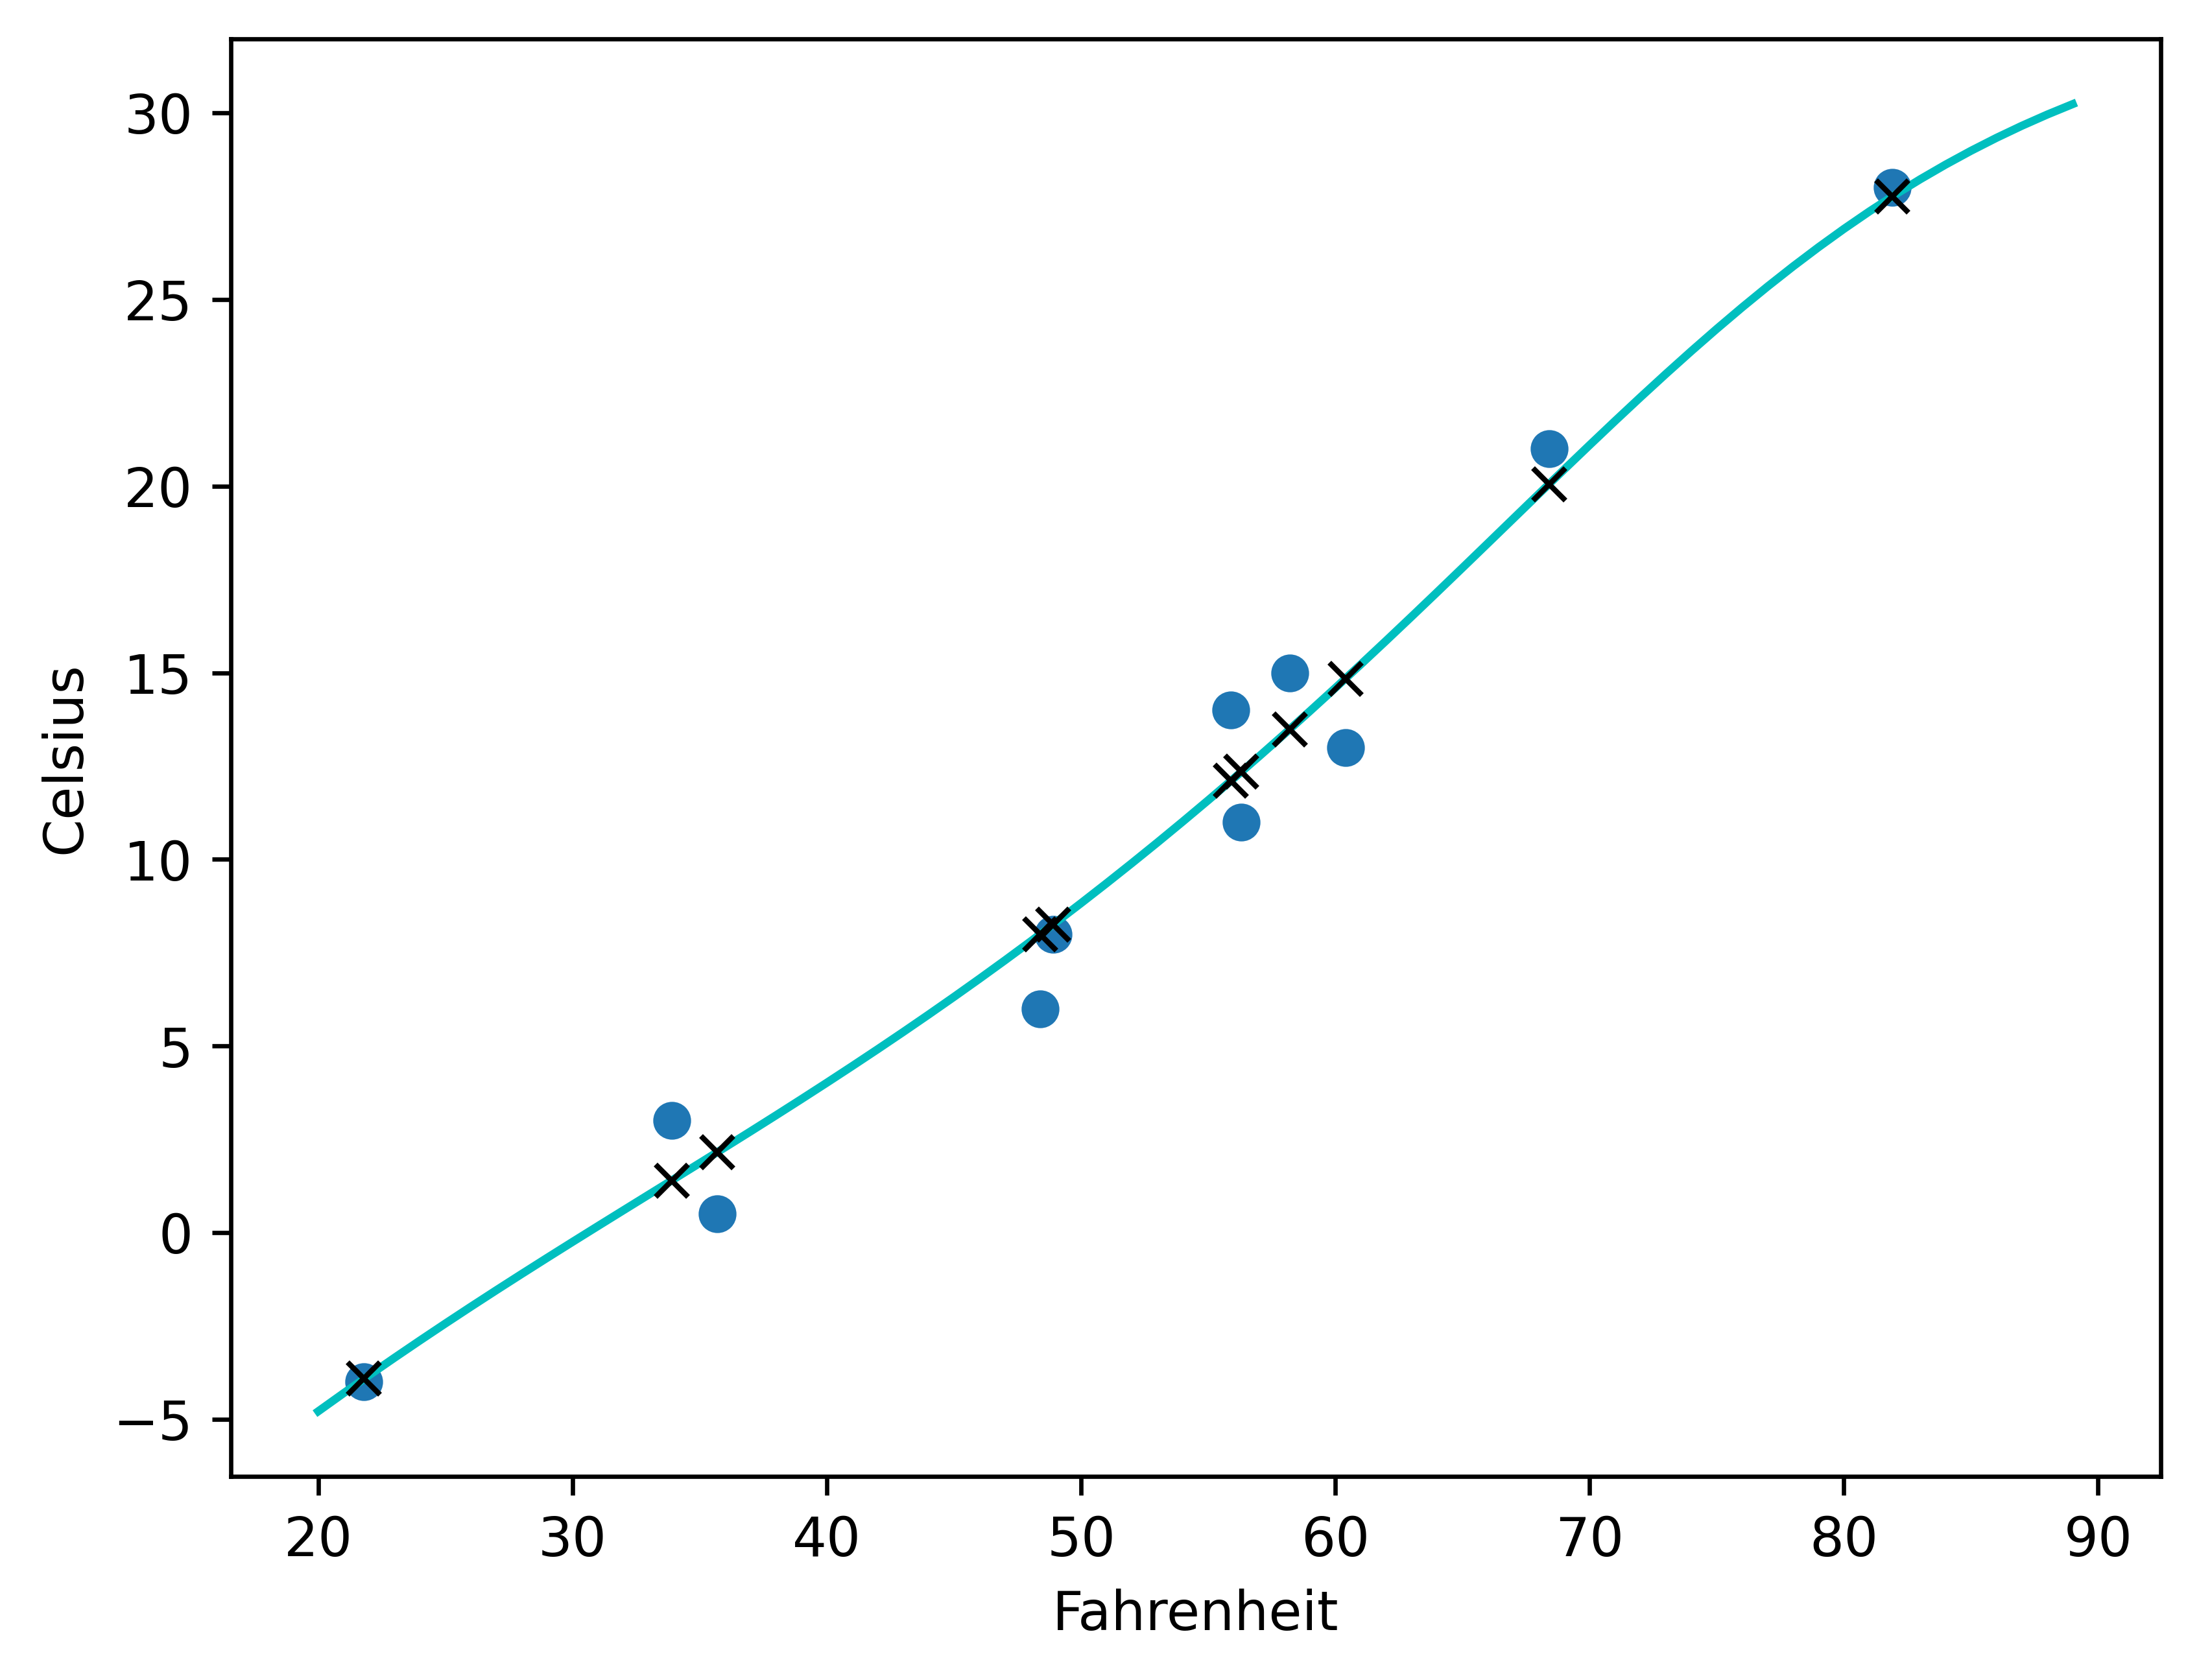

In [31]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

# Summary

* Neural networks can be automatically adapted to specialize themselves on the
problem at hand.
* Neural networks allow easy access to the analytical derivatives of the loss with
respect to any parameter in the model, which makes evolving the parameters
very efficient. Thanks to its automated differentiation engine, PyTorch provides
such derivatives effortlessly.
* Activation functions around linear transformations make neural networks capa-
ble of approximating highly nonlinear functions, at the same time keeping
them simple enough to optimize.
The nn module together with the tensor standard library provide all the build-
ing blocks for creating neural networks.
* To recognize overfitting, it’s essential to maintain the training set of data points
separate from the validation set. There’s no one recipe to combat overfitting,
but getting more data, or more variability in the data, and resorting to simpler
models are good starts.
* Anyone doing data science should be plotting data all the time.